In [587]:
# On affiche les graphiques dans le notebook en statique
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import time

# from copy import deepcopy
import cudf
import cuml
import os
import gc
import mlflow
import cupy as cp
from cuml import LogisticRegression as CuLogisticRegression
from cuml.pipeline import Pipeline as CuPipeline
from cuml.preprocessing import StandardScaler as CuStandardScaler
from cuml.preprocessing import SimpleImputer as CuSimpleImputer


# from cuml.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# import seaborn as sns
import joblib

# from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE


from src.modeling.p7_util import format_time, save_pkl, read_pkl

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:

from src.modeling.p7_constantes import (
    DATA_CLEAN_DIR,
    MODEL_DIR,
    VAL_SEED,
)

from src.modeling.p7_util import reduce_memory_cudf
from src.modeling.p7_evaluate import EvaluatorCV
from src.modeling.p7_importance import (
    importance_from_model,
    plot_line_importance,
    plot_bar_importances,
)
from src.modeling.p7_comparative_table import ComparativeTable
from src.modeling.p7_rfecv import RfecvSelector
from src.modeling.p7_tracking import start_mlflow_ui, create_or_load_experiment


from src.modeling.p7_tracking import merge_dicts_with_prefixes, pil_image_from_fig
from src.modeling.p7_tracking import log_features, log_scoring_params, log_image


%load_ext autoreload
%autoreload 2
#autoreload 2 = Reload all modules (except those excluded by %aimport)
# every time before executing the Python code typed.

In [3]:
pd.set_option("display.max_colwidth", 400)

In [4]:
print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)
print("mlflow version:", mlflow.__version__)

cuDF version: 24.04.01
cuML version: 24.04.00
mlflow version: 2.13.0


## Fonctions codées pour ce notebook

In [5]:
def save_features(features, name, directory=MODEL_DIR, verbose=True):
    path_features = os.path.join(directory, f"{name}.pkl")
    joblib.dump(features, path_features)
    if verbose:
        print(
            f"Liste des features (Nb = {len(features)}) engistrée dans {path_features}"
        )
    return

In [6]:
def read_features(name, directory=MODEL_DIR, verbose=True):
    path_features = os.path.join(directory, f"{name}.pkl")
    features = joblib.load(path_features)
    if verbose:
        print(f"Liste des features (Nb = {len(features)}) lue dans {path_features}")
    return features

In [7]:
def read_sample(
    name="01_v2_vif_sampled_train.csv",
    to_cpu=False,
    directory=DATA_CLEAN_DIR,
    verbose=True,
):
    sampled_train = cudf.read_csv(os.path.join(directory, name))
    if to_cpu:
        sampled_train = sampled_train.to_pandas()
    predictors = [f for f in sampled_train.columns if f not in ["SK_ID_CURR", "TARGET"]]
    X = sampled_train[predictors]
    y = sampled_train["TARGET"]
    if verbose:
        print("Info X :")
        print(X.info())
        print("\nInfo y :")
        print("Classe", y.__class__.__name__)
        print("Type", y.dtype)
        print("Shape", y.shape)
    return X, y

In [8]:
def read_train(train_name="01_v2_vif_train.csv", features=[], optim=True):
    if features:
        train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, train_name))[
            features + ["SK_ID_CURR", "TARGET"]
        ].set_index("SK_ID_CURR")
    else:
        train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, train_name)).set_index(
            "SK_ID_CURR"
        )
    if optim:
        train = reduce_memory_cudf(train)
    X = train[features].to_pandas()
    y = train["TARGET"].to_pandas()
    print("\nInfo X_train")
    X.info()
    return X, y

## Lecture des données de train

In [9]:
train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv"))
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 426 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(249), int64(31)
memory usage: 532.2 MB


In [554]:
N_ROWS = train.shape[0]
print("Nombre de lignes dans la totalité du train :", N_ROWS)

Nombre de lignes dans la totalité du train : 230634


In [604]:
train = reduce_memory_cudf(train)

Memory usage of dataframe is 532.18 MB
Memory usage after optimization is: 302.55 MB
Decreased by 43.1%


In [556]:
predictors = [f for f in train.columns if f not in ["SK_ID_CURR", "TARGET"]]
X = train[predictors].to_pandas()
y = train["TARGET"].to_pandas()

# Echantillonnage

## Réduction du nombre de lignes

### Echantillon 30%

In [220]:
sampled_train, _ = sk_train_test_split(
    train.to_pandas(),
    test_size=0.7,
    stratify=train["TARGET"].to_pandas(),
    shuffle=True,
    random_state=VAL_SEED,
)
sampled_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69190 entries, 170245 to 38394
Columns: 426 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float32(242), float64(29), int32(7), int64(2)
memory usage: 92.2 MB


### Sauvegarde de l'échantillon

In [221]:
filepath = os.path.join(DATA_CLEAN_DIR, "01_v2_vif_sampled_train.csv")
sampled_train.to_csv(filepath, index=False)
print(f"Echantillon (30% des données) enregistré dans {filepath}")

Echantillon (30% des données) enregistré dans data/cleaned/01_v2_vif_sampled_train.csv


# Dummy classifier sur toutes les features

In [16]:
X, y = read_sample(to_cpu=True)
n_features = len(X.columns)
print()

model = DummyClassifier(strategy="most_frequent")
evaluator0 = EvaluatorCV(pipe=model, device="CPU", cv=5, random_state=VAL_SEED)
_ = evaluator0.evaluate(X, y)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(271), int64(7)
memory usage: 156.4 MB
None

Info y :
Classe Series
Type int64
Shape (69190,)

Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:01


In [17]:
evaluator0.param_bg

{'loss_fn': -50000, 'loss_fp': -5000, 'gain_tp': 5000, 'gain_tn': 0}

In [18]:
evaluator0.get_mean_val_scores()

{'auc': 0.5,
 'accuracy': 0.9192224309871369,
 'recall': 0.0,
 'f1_score': 0.0,
 'business_gain': 0.508482586715428,
 'fit_time': 0.0010952949523925781,
 'tn': 12720.2,
 'tp': 0.0,
 'fn': 1117.8,
 'fp': 0.0}

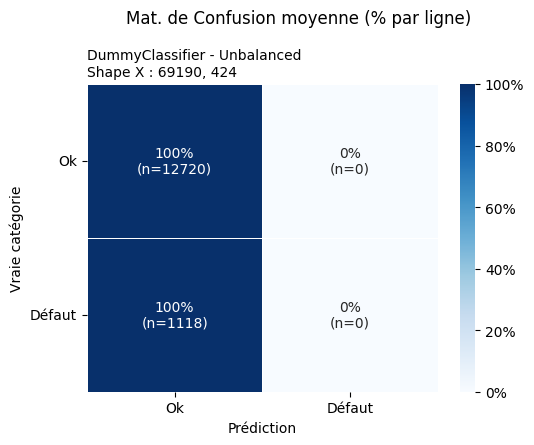

In [19]:
evaluator0.plot_conf_mat()

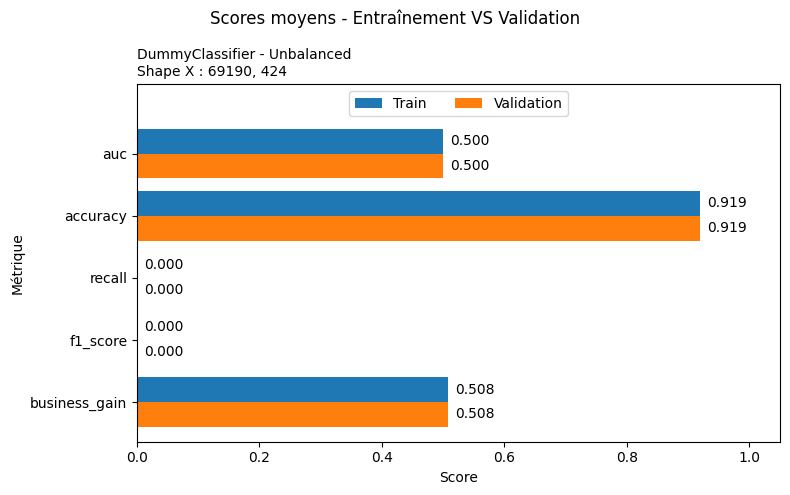

In [20]:
_ = evaluator0.plot_evaluation_scores()

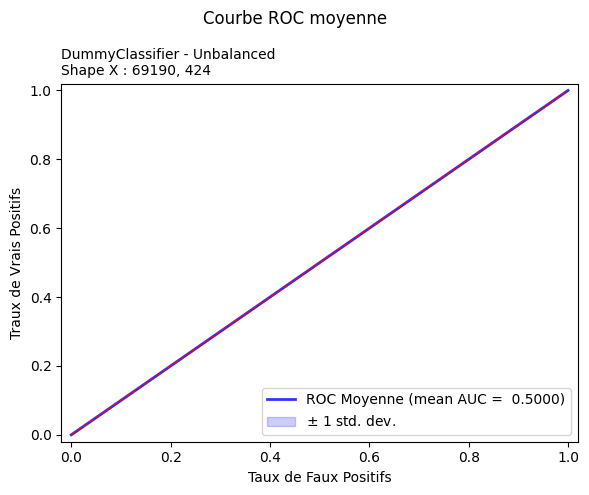

In [21]:
fig = evaluator0.plot_roc_curve()

In [22]:
evaluator0.get_mean_val_scores()

{'auc': 0.5,
 'accuracy': 0.9192224309871369,
 'recall': 0.0,
 'f1_score': 0.0,
 'business_gain': 0.508482586715428,
 'fit_time': 0.0010952949523925781,
 'tn': 12720.2,
 'tp': 0.0,
 'fn': 1117.8,
 'fp': 0.0}

# Régression logistique sur toutes les features, échantillon 30%

## Avec cuml

In [23]:
pipe_cuml = CuPipeline(
    [
        ("imputer", CuSimpleImputer(copy=False)),
        # ("std", VarianceSelector(copy=False)),
        ("scaler", CuStandardScaler(copy=False)),
        ("clf", cuml.LogisticRegression()),
    ]
)

In [24]:
X, y = read_sample(to_cpu=False)
evaluator_cuml = EvaluatorCV(pipe=pipe_cuml, device="GPU")
evaluator_cuml.evaluate(X, y)

Info X :
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(271), int64(7)
memory usage: 158.6 MB
None

Info y :
Classe Series
Type int64
Shape (69190,)
Durée de l'évaluation en validation croisée sur GPU (5 folds): 0:00:15


In [25]:
evaluator_cuml.get_mean_val_scores()

{'auc': 0.7574572119950027,
 'accuracy': 0.9186154098141228,
 'recall': 0.033280589619204264,
 'f1_score': 0.06185652080455382,
 'business_gain': 0.5230175299007513,
 'fit_time': 1.130521297454834,
 'tn': 12674.6,
 'tp': 37.2,
 'fn': 1080.6,
 'fp': 45.6}

In [26]:
pd.Series(evaluator_cuml.get_model_params())

handle                 <pylibraft.common.handle.Handle object at 0x7fde356c6c40>
verbose                                                                        4
output_type                                                                input
penalty                                                                       l2
tol                                                                       0.0001
C                                                                            1.0
fit_intercept                                                               True
class_weight                                                                None
max_iter                                                                    1000
linesearch_max_iter                                                           50
l1_ratio                                                                    None
solver                                                                        qn
dtype: object

## Avec sklearn

In [27]:
pipe_sklearn = Pipeline(
    [
        ("imputer", SimpleImputer(copy=False)),
        ("scaler", StandardScaler(copy=False)),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs",
                n_jobs=14,
                max_iter=1000,
                warm_start=False,
                random_state=VAL_SEED,
            ),
        ),
    ]
)

In [28]:
X, y = read_sample(to_cpu=True)
evaluator_sklearn = EvaluatorCV(pipe=pipe_sklearn, device="CPU")
evaluator_sklearn.evaluate(X, y)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(271), int64(7)
memory usage: 156.4 MB
None

Info y :
Classe Series
Type int64
Shape (69190,)
Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:10


In [29]:
evaluator_sklearn.get_mean_val_scores()

{'auc': 0.7589296024126553,
 'accuracy': 0.9183986125162595,
 'recall': 0.030953887153008553,
 'f1_score': 0.05774735595447304,
 'business_gain': 0.5218580760048542,
 'fit_time': 1.2654426097869873,
 'tn': 12674.2,
 'tp': 34.6,
 'fn': 1083.2,
 'fp': 46.0}

In [30]:
pd.DataFrame(
    {
        "cuml": evaluator_cuml.get_model_params(),
        "sklearn lfgs": evaluator_sklearn.get_model_params(),
    }
)

,cuml,sklearn lfgs
handle,<pylibraft.common.handle.Handle object at 0x7fde356c6c40>,NaN
verbose,4,0
output_type,input,NaN
penalty,l2,l2
tol,0.0001,0.0001
C,1.0,1.0
fit_intercept,True,True
class_weight,None,None
max_iter,1000,1000
linesearch_max_iter,50,NaN


In [31]:
pd.DataFrame(
    {
        "cuml": evaluator_cuml.get_mean_val_scores(),
        "sklearn lbfgs": evaluator_sklearn.get_mean_val_scores(),
    }
)

,cuml,sklearn lbfgs
auc,0.757457,0.758930
accuracy,0.918615,0.918399
recall,0.033281,0.030954
f1_score,0.061857,0.057747
business_gain,0.523018,0.521858
fit_time,1.130521,1.265443
tn,12674.600000,12674.200000
tp,37.200000,34.600000
fn,1080.600000,1083.200000
fp,45.600000,46.000000


## Réduction du nombre de features à l'aide d'un modèle à base d'arbres

### Importances moyennes sur toutes les features et toutes les lignes

In [32]:
X = train.drop(columns=["SK_ID_CURR", "TARGET"]).to_pandas()
y = train["TARGET"].to_pandas()

print("Info X :")
print(X.info())
print("\nInfo y :")
print("Classe", y.__class__.__name__)
print("Type", y.dtype)
print("Shape", y.shape)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float32(242), float64(29), int32(5), int64(2)
memory usage: 304.0 MB
None

Info y :
Classe Series
Type int32
Shape (230634,)


In [33]:
clf = LGBMClassifier(
    n_threads=14,
    class_weight="balanced",
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)

In [34]:
params = clf.get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'n_threads': 14,
 'verbosity': -1}

In [35]:
t0 = time.time()
importances = importance_from_model(clf, X, y, n_splits=5)
duration = time.time() - t0
print(f"Durée du calcul des importances : {format_time(duration)}")
importances.head()

Durée du calcul des importances : 0:00:19


,importance_mean,importance_std,rank_importance,missing_pct
feature,,,,
EXT_SOURCE_1,127.6,6.188699,1,56.289185
CREDIT_TO_ANNUITY_RATIO,127.6,10.358571,2,0.003469
EXT_SOURCE_2,120.8,4.324350,3,0.208556
EXT_SOURCE_3,105.0,8.888194,4,19.816679
DAYS_EMPLOYED,70.6,2.509980,5,18.019459


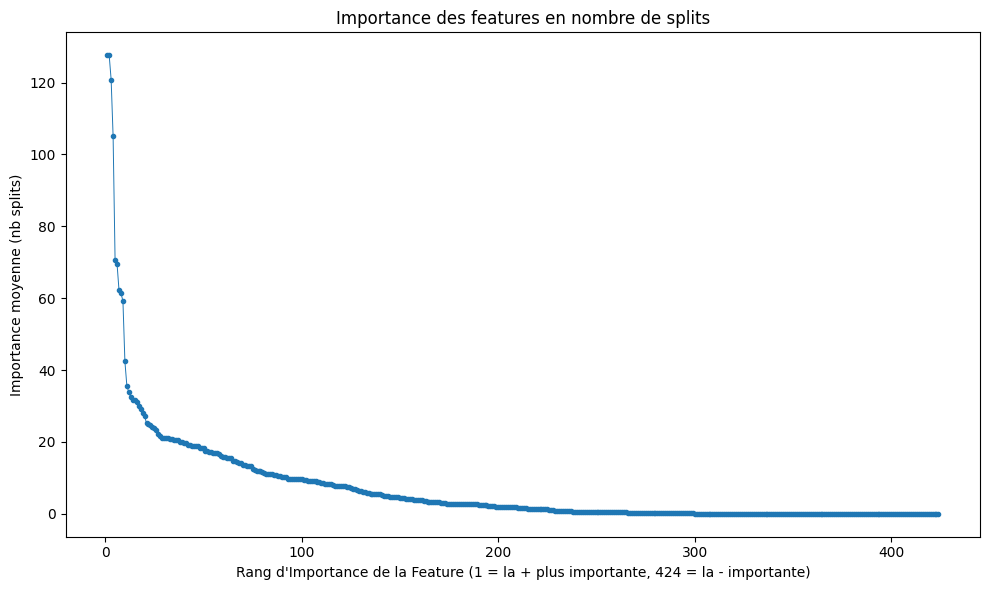

In [36]:
fig_line_importance = plot_line_importance(importances)

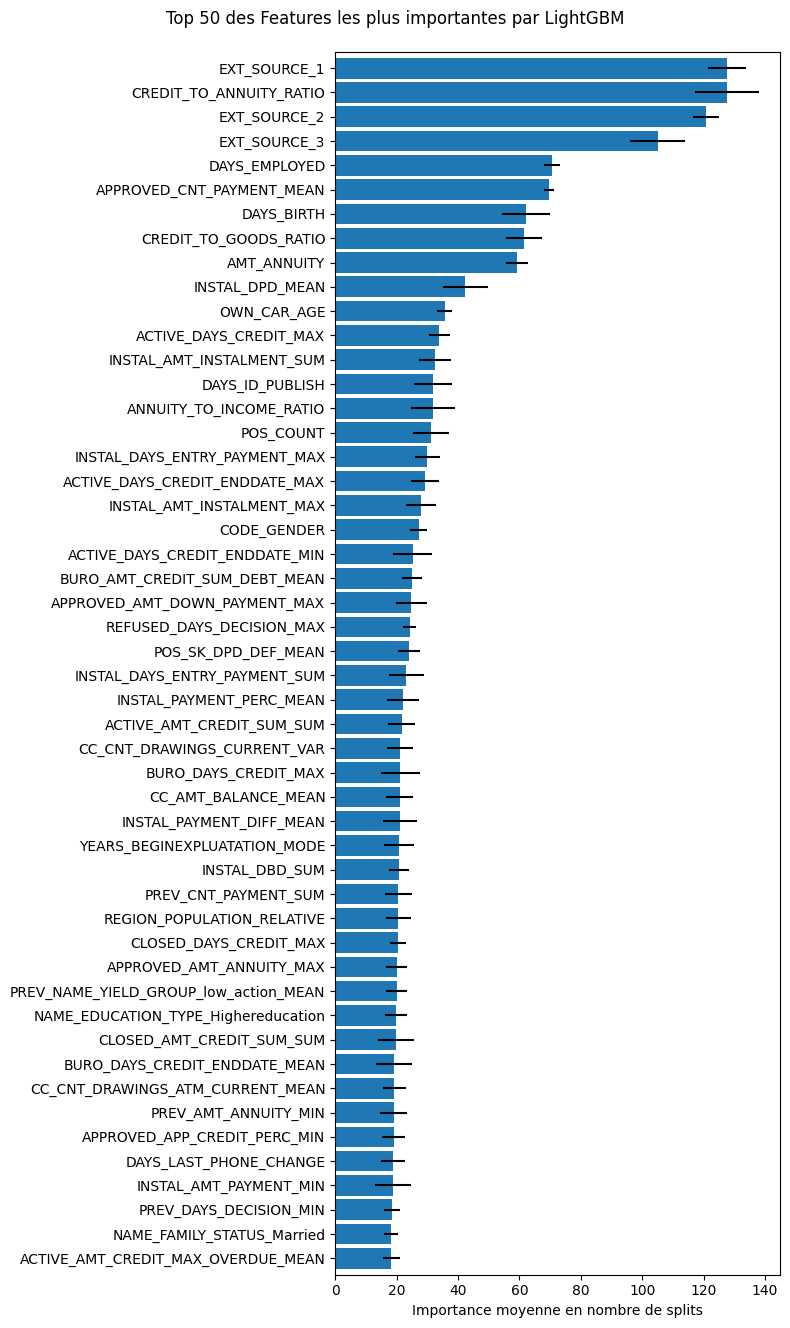

In [37]:
fig_bar_importance = plot_bar_importances(importances, top=50)

### Sauvegarde liste des features triée par importance

In [38]:
features_sorted_importance = list(importances.index)
save_features(features_sorted_importance, "features_sorted_importance")

Liste des features (Nb = 424) engistrée dans models/features_sorted_importance.pkl


### Choix du nombre de features réduit

#### Sur une régression logistique

In [39]:
X_all_features, y = read_sample(to_cpu=True)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(271), int64(7)
memory usage: 156.4 MB
None

Info y :
Classe Series
Type int64
Shape (69190,)


In [40]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(copy=False)),
        ("scaler", StandardScaler(copy=False)),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs", class_weight="balanced", n_jobs=14, max_iter=1000
            ),
        ),
    ]
)


Avec 424 features
Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:11
Business gain Train : 0.7103,	Business gain Validation : 0.6926

Avec 60 features
Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:05
Business gain Train : 0.6919,	Business gain Validation : 0.6889

Avec 40 features
Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:07
Business gain Train : 0.6866,	Business gain Validation : 0.6840

Avec 20 features
Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:07
Business gain Train : 0.6709,	Business gain Validation : 0.6703


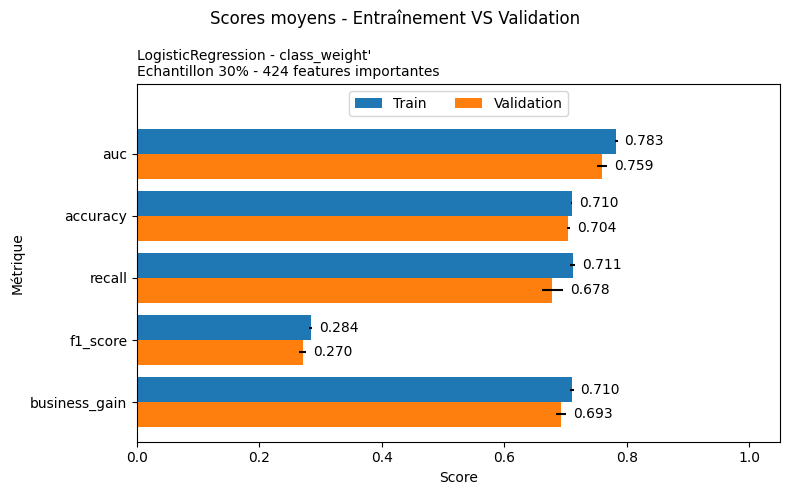

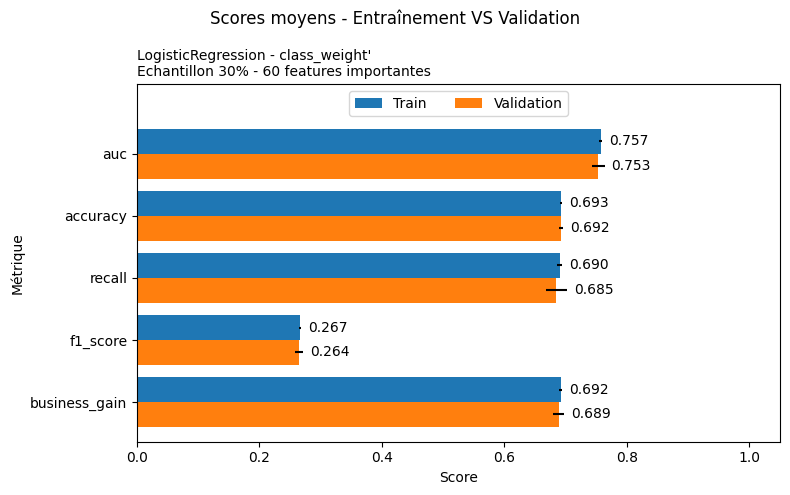

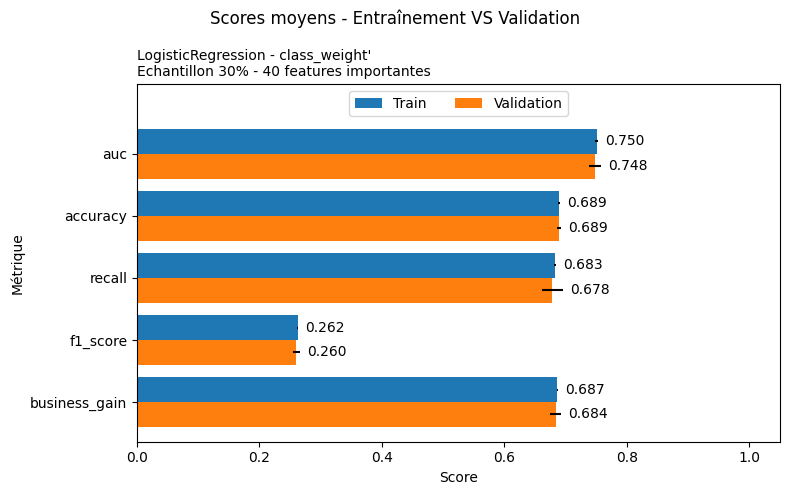

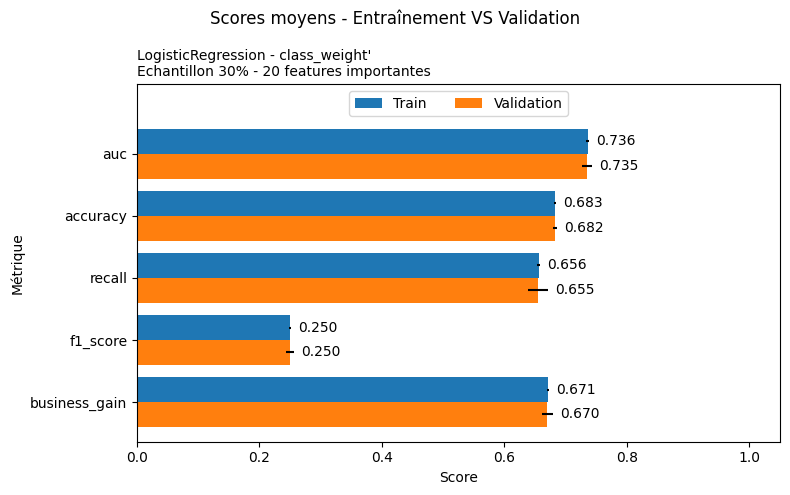

In [41]:
business_gains = []
for i, n_features in enumerate([424, 60, 40, 20, 10]):
    features = features_sorted_importance[:n_features]
    print(f"\nAvec {n_features} features")
    X = X_all_features[features]
    evaluator = EvaluatorCV(pipe=pipe, cv=5, device="CPU", random_state=VAL_SEED)
    evaluator.evaluate(
        X,
        y,
    )

    # On retient les business gain et les fit_time dans une liste de dictionnaires pour pouvoir les comparer facilement ensuite
    business_gain_train, business_gain_val = evaluator.get_business_gain()

    fit_time = evaluator.get_mean_train_scores(prefix="")["fit_time"]
    dic_bg = {
        "Nb features": f"{len(features)} features",
        "business-gain_train": f"{business_gain_train:.4f}",
        "business_gain_val": f"{business_gain_val:.4f}",
        "fit_time": f"{fit_time * 1000:.0f}",
    }
    business_gains.append(dic_bg)

    # On compare les scores de train et de validation dans un graphique pour mieux visualiser le risque de surfit
    subtitle_plot = f"{evaluator.model.__class__.__name__} - class_weight'\nEchantillon 30% - {len(features)} features importantes"
    evaluator.plot_evaluation_scores(subtitle=subtitle_plot)

    if i == 0:
        business_gain_start = business_gain_val
    if business_gain_val < business_gain_start - 0.01:
        break

# On met les business_gains dans un tableau récapitulatif
business_gains_df = pd.DataFrame(business_gains)

In [42]:
# On affiche le tableau récaputulatif
print("\nRécapitulatif sur la Régression logistique")
display(business_gains_df)


Récapitulatif sur la Régression logistique


,Nb features,business-gain_train,business_gain_val,fit_time
0,424 features,0.7103,0.6926,1683
1,60 features,0.6919,0.6889,1195
2,40 features,0.6866,0.6840,1097
3,20 features,0.6709,0.6703,1059


In [43]:
"""
On choisit 40 features.
    - La perte de business_gain sur le jeu de validation est acceptable
    - On gagne du temps et de la consommation mémoire
    - Pas de surfit
"""

'\nOn choisit 40 features.\n    - La perte de business_gain sur le jeu de validation est acceptable\n    - On gagne du temps et de la consommation mémoire\n    - Pas de surfit\n'

# Données

In [44]:
n_features = 40

In [45]:
all_features = read_pkl("features_sorted_importance", verbose=False)
features = all_features[:n_features]

In [46]:
X_all_features, y = read_sample(to_cpu=True)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(271), int64(7)
memory usage: 156.4 MB
None

Info y :
Classe Series
Type int64
Shape (69190,)


In [47]:
X = X_all_features[features].copy()

# Régression Logistique 40 features - Tests de stratégie de rééquilibrage

## Création de l'expérience MLFlow pour tracer les expérimentations sur les stratégies de rééquilibrage

In [48]:
# On démarre l'interface web de MLFlow
# Ou tout simplement en ligne de commande :
# mlflow server --host 127.0.0.1 --port 5000 ou mlflow server --host localhost --port 5000
_ = start_mlflow_ui()

L'interface web mlflow est disponible à l'adresse http://127.0.0.1:5000


In [49]:
exp_balancing_id = create_or_load_experiment(
    name="balancing_strategies",
    description="Tests de stratégies de rééquilibrage sur échantillon de 30% en cross_validation 5 folds",
)

Création de l'expérience MLFlow 'balancing_strategies', ID = 606950933699482346


## LOGREG Unbalanced 40 features

### Initialisation

#### Pipe / modèle

In [50]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs", class_weight=None, n_jobs=14, max_iter=1000
            ),
        ),
    ]
)

In [51]:
evaluator1 = EvaluatorCV(pipe=pipe, cv=5, device="CPU", random_state=VAL_SEED)

In [52]:
run_name = "logreg_unbalanced"
run_tags = {"balancing": evaluator1.balance_str}
run_description = "Régression Logistique non optimisée - unbalanced"

#### Exécution dans un run mlflow

In [53]:
with mlflow.start_run(
    experiment_id=exp_balancing_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator1.evaluate(X, y)
    _ = evaluator1.get_business_gain()

Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:08
Business gain Train : 0.5141,	Business gain Validation : 0.5139


#### Traçage des scores et des paramètres dans mlflow

In [54]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator1.get_mean_val_scores(prefix="val_")
    train_scores = evaluator1.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = merge_dicts_with_prefixes(
        model=evaluator1.get_model_params(), metric=evaluator1.get_metric_params()
    )
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

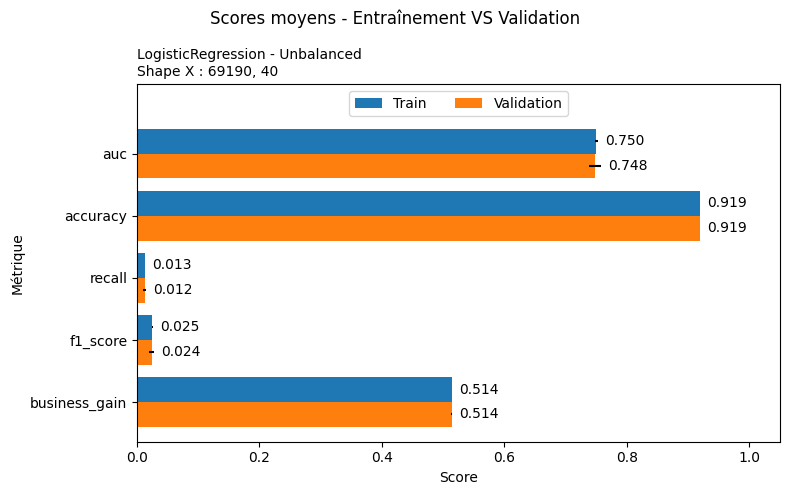

In [166]:
fig = evaluator1.plot_evaluation_scores()

In [56]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig((fig))
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")

### Plot Matrice confusion

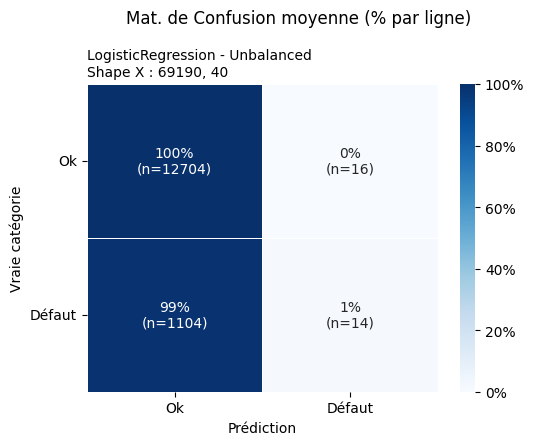

In [57]:
fig = evaluator1.plot_conf_mat()
fig

In [58]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig((fig))
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")

### Plot Roc Curve

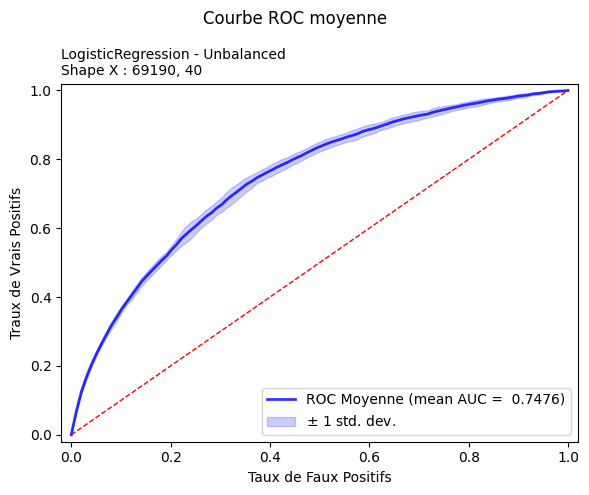

In [59]:
fig = evaluator1.plot_roc_curve()

In [60]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig((fig))
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")

### Ajout au tableau comparatif

In [61]:
cmp = ComparativeTable(title="Comparatif Rééquilibrage")
cmp.add(
    evaluator0,
)
cmp.set_duration_format({"fit_time": "{:.1f}"})
cmp.set_column_order(
    [
        "model_name",
        "balancing",
        "business_gain",
        "auc",
        "accuracy",
        "recall",
        "f1_score",
        "fit_time",
        "n_rows",
        "n_feat.",
    ]
)
cmp.add(evaluator1)
cmp.display()

Comparatif Rééquilibrage


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40


## Class_weight

### Exécution

In [62]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs", class_weight="balanced", n_jobs=14, max_iter=1000
            ),
        ),
    ]
)

In [63]:
evaluator2 = EvaluatorCV(pipe=pipe, cv=5, device="CPU", random_state=VAL_SEED)

In [64]:
run_name = "logreg_weight"
run_tags = {"balancing": evaluator2.balance_str}
run_description = "Régression Logistique non optimisée - class_weight"

#### Exécution dans un run mlflow

In [65]:
with mlflow.start_run(
    experiment_id=exp_balancing_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator2.evaluate(X, y)
    _ = evaluator2.get_business_gain()

Durée de l'évaluation en validation croisée sur CPU (5 folds): 0:00:08
Business gain Train : 0.6866,	Business gain Validation : 0.6840


#### Traçage des scores et des paramètres dans mlflow

In [66]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator2.get_mean_val_scores(prefix="val_")
    train_scores = evaluator2.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = merge_dicts_with_prefixes(
        model=evaluator2.get_model_params(), metric=evaluator2.get_metric_params()
    )
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

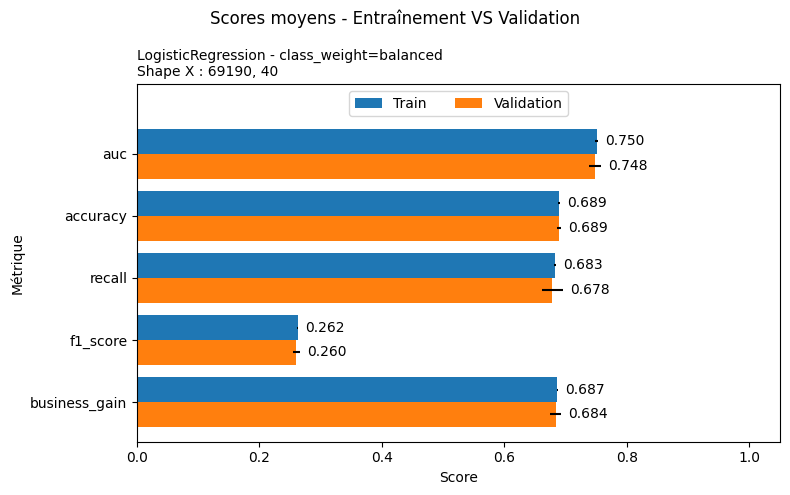

In [167]:
fig = evaluator2.plot_evaluation_scores()

In [68]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")

### Plot Matrice confusion

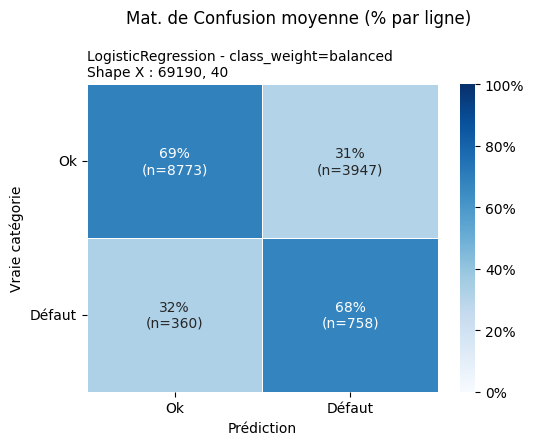

In [69]:
fig = evaluator2.plot_conf_mat()
fig

In [70]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")

### Plot Roc Curve

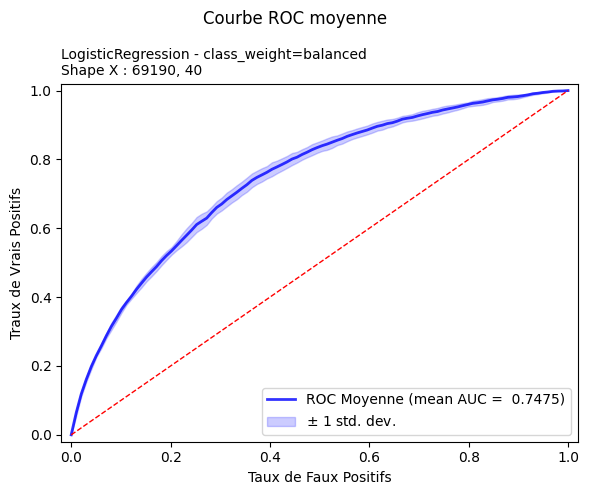

In [71]:
fig = evaluator2.plot_roc_curve()

In [72]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")

### Ajout au tableau comparatif

In [73]:
cmp.add(evaluator2)

cmp.display()

Comparatif Rééquilibrage


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40
2,LogisticRegression,class_weight=balanced,0.6840,0.7477,0.6888,0.6781,0.2603,1.2,69190,40


## SMOTE (paramètres par défaut)

### Exécution

In [75]:
pipe = ImblearnPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=5, n_jobs=14, random_state=VAL_SEED)),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs", class_weight="balanced", n_jobs=14, max_iter=1000
            ),
        ),
    ]
)

In [76]:
evaluator3 = EvaluatorCV(pipe=pipe, device="cpu", cv=5, random_state=42)
run_name = "logreg_smote"
run_tags = {"balancing": evaluator3.balance_str}
run_description = "Régression Logistique non optimisée - smote"

with mlflow.start_run(
    experiment_id=exp_balancing_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator3.evaluate(X, y)
    _ = evaluator3.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:09
Business gain Train : 0.6856,	Business gain Validation : 0.6833


In [77]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator3.get_mean_val_scores(prefix="val_")
    train_scores = evaluator3.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = merge_dicts_with_prefixes(
        model=evaluator3.get_model_params(), metric=evaluator3.get_metric_params()
    )
    mlflow.log_params(params)

### LOGREG SMOTE - Ajout au tableau comparatif

In [78]:
cmp.add(evaluator3)

cmp.display()

Comparatif Rééquilibrage


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40
2,LogisticRegression,class_weight=balanced,0.6840,0.7477,0.6888,0.6781,0.2603,1.2,69190,40
3,LogisticRegression,SMOTE,0.6833,0.7456,0.6897,0.6754,0.2602,1.3,69190,40


### Plot Scores d'entraînement et de validation

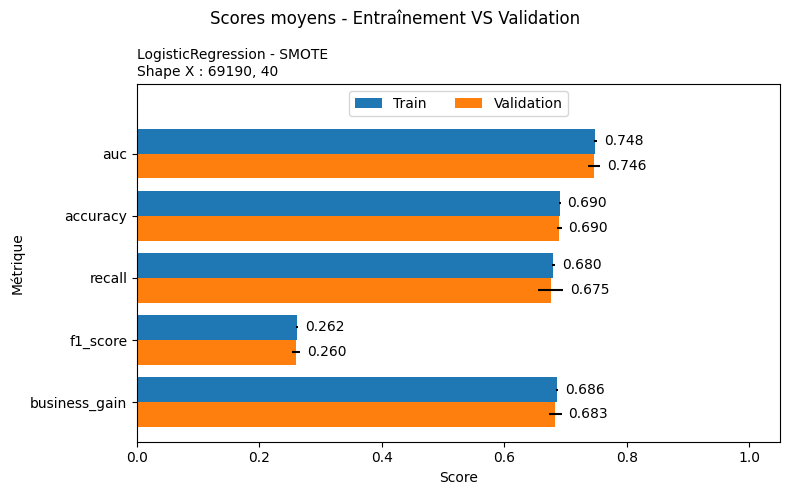

In [79]:
fig = evaluator3.plot_evaluation_scores()

In [80]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")

### Plot Matrice confusion

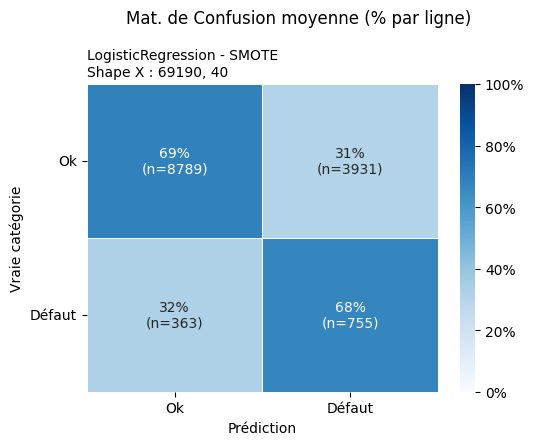

In [81]:
fig = evaluator3.plot_conf_mat()
fig

In [82]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")

### Plot Roc Curve

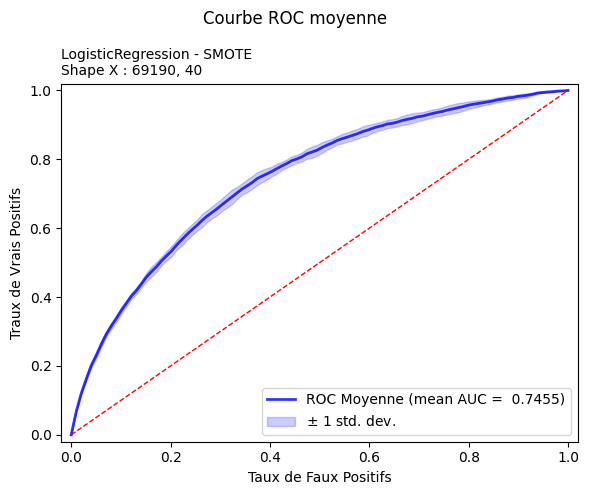

In [83]:
fig = evaluator3.plot_roc_curve()

In [84]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")

# Tests rééquilibrage pour LightGBM 40 features

In [85]:
n_features = 40

In [86]:
all_features = read_features("features_sorted_importance", verbose=False)
features = all_features[:n_features]

In [87]:
X_all_features, y = read_sample(to_cpu=True)

Info X :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69190 entries, 0 to 69189
Columns: 424 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(271), int64(7)
memory usage: 156.4 MB
None

Info y :
Classe Series
Type int64
Shape (69190,)


In [88]:
X = X_all_features[features]

## LightGBM Unbalanced

### Exécution LightGBM Unbalanced

In [89]:
model = LGBMClassifier(
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)

evaluator4 = EvaluatorCV(pipe=model, device="cpu", cv=5, random_state=VAL_SEED)
run_name = "lightgbm_unbalanced"
run_tags = {"balancing": evaluator4.balance_str}
run_description = "LightGBM non optimisée - Unbalanced"

with mlflow.start_run(
    experiment_id=exp_balancing_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator4.evaluate(X, y)
    _ = evaluator4.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:03
Business gain Train : 0.5664,	Business gain Validation : 0.5274


In [90]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator4.get_mean_val_scores(prefix="val_")
    train_scores = evaluator4.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = merge_dicts_with_prefixes(
        model=evaluator4.get_model_params(), metric=evaluator4.get_metric_params()
    )
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

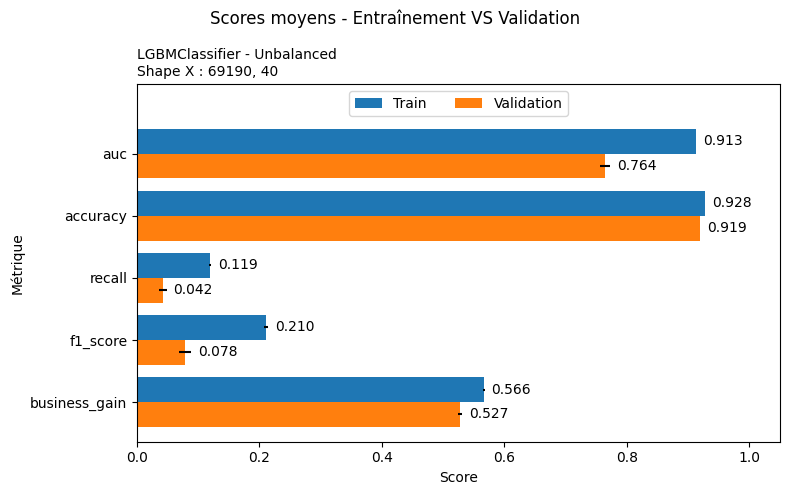

In [168]:
fig = evaluator4.plot_evaluation_scores()

In [92]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")

### Plot Matrice confusion

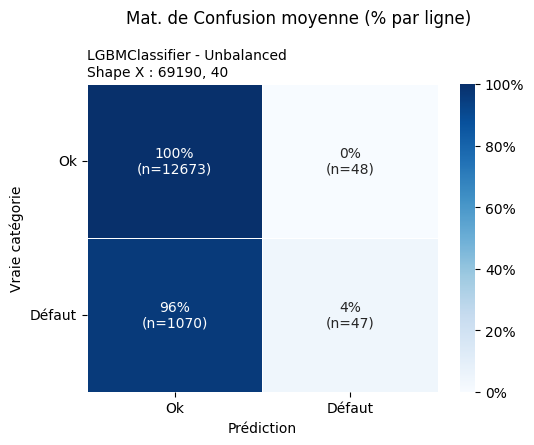

In [93]:
fig = evaluator4.plot_conf_mat()
fig

In [94]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")

### Plot Roc Curve

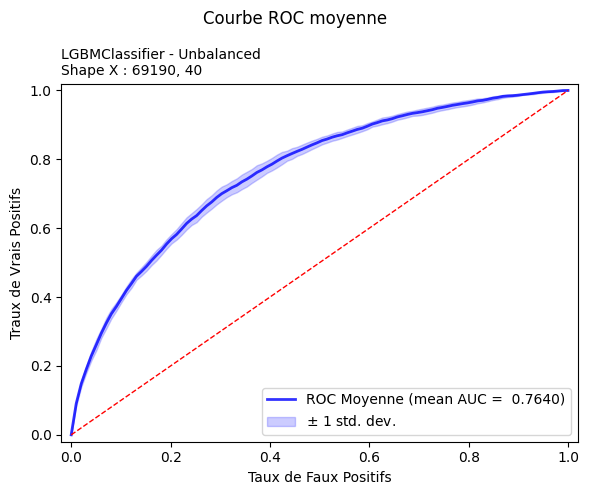

In [95]:
fig = evaluator4.plot_roc_curve()

In [96]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")

### Ajout au tableau comparatif

In [97]:
cmp.add(evaluator4)
cmp.display()

Comparatif Rééquilibrage


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40
2,LogisticRegression,class_weight=balanced,0.6840,0.7477,0.6888,0.6781,0.2603,1.2,69190,40
3,LogisticRegression,SMOTE,0.6833,0.7456,0.6897,0.6754,0.2602,1.3,69190,40
4,LGBMClassifier,Unbalanced,0.5274,0.7642,0.9192,0.0424,0.0781,0.3,69190,40


## LightGBM Class_weight

### Exécution LightGBM Class_weight

In [98]:
model = LGBMClassifier(
    class_weight="balanced",
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)

evaluator5 = EvaluatorCV(pipe=model, device="cpu", cv=5, random_state=VAL_SEED)
run_name = "lightgbm_class_weight"
run_tags = {"balancing": evaluator5.balance_str}
run_description = "LightGBM non optimisée - Class_weight"

with mlflow.start_run(
    experiment_id=exp_balancing_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator5.evaluate(X, y)
    _ = evaluator5.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:03
Business gain Train : 0.8217,	Business gain Validation : 0.6942


In [99]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator5.get_mean_val_scores(prefix="val_")
    train_scores = evaluator5.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = merge_dicts_with_prefixes(
        model=evaluator5.get_model_params(), metric=evaluator5.get_metric_params()
    )
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

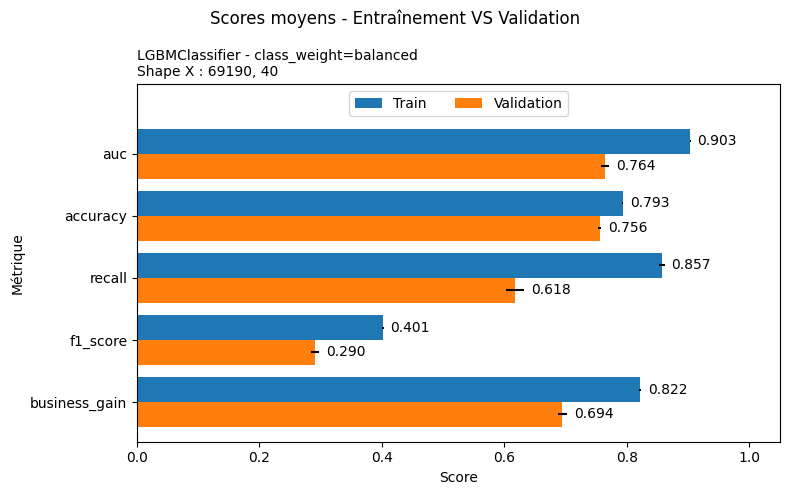

In [169]:
fig = evaluator5.plot_evaluation_scores()

In [101]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")

### Plot Matrice confusion

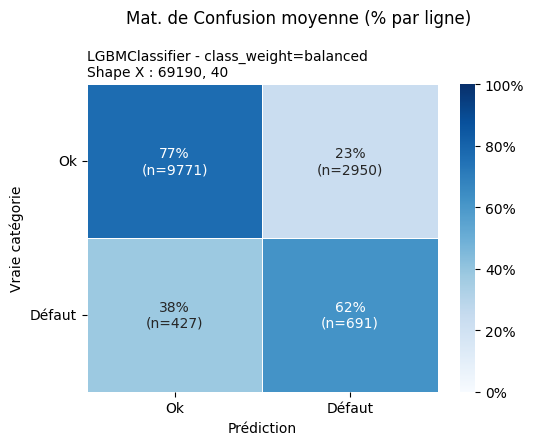

In [102]:
fig = evaluator5.plot_conf_mat()
fig

In [103]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")

### Plot Roc Curve

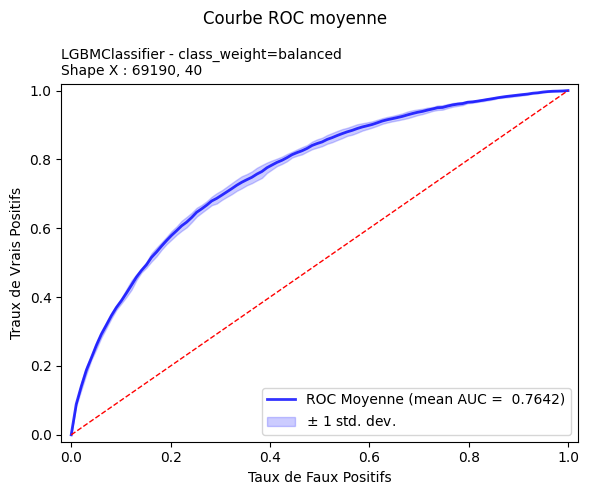

In [104]:
fig = evaluator5.plot_roc_curve()

In [105]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")

### Ajout au tableau comparatif

In [106]:
cmp.add(evaluator5)
cmp.display()

Comparatif Rééquilibrage


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40
2,LogisticRegression,class_weight=balanced,0.6840,0.7477,0.6888,0.6781,0.2603,1.2,69190,40
3,LogisticRegression,SMOTE,0.6833,0.7456,0.6897,0.6754,0.2602,1.3,69190,40
4,LGBMClassifier,Unbalanced,0.5274,0.7642,0.9192,0.0424,0.0781,0.3,69190,40
5,LGBMClassifier,class_weight=balanced,0.6942,0.7643,0.7560,0.6178,0.2903,0.3,69190,40


## SMOTE LightGBM

### Exécution smote lightGBM

In [107]:
pipe = ImblearnPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=5, n_jobs=14, random_state=VAL_SEED)),
        (
            "clf",
            LGBMClassifier(
                n_threads=14,
                objective="binary",
                random_state=VAL_SEED,
                verbosity=-1,  # Pour ne pas voir les logs
            ),
        ),
    ]
)

In [108]:
evaluator6 = EvaluatorCV(pipe=pipe, device="cpu", cv=5, random_state=VAL_SEED)
run_name = "lightgbm_smote"
run_tags = {"balancing": evaluator6.balance_str}
run_description = "LightGBM non optimisée - SMOTE"

with mlflow.start_run(
    experiment_id=exp_balancing_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator6.evaluate(X, y)
    _ = evaluator6.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:06
Business gain Train : 0.5687,	Business gain Validation : 0.5555


In [109]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator6.get_mean_val_scores(prefix="val_")
    train_scores = evaluator6.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = merge_dicts_with_prefixes(
        model=evaluator6.get_model_params(), metric=evaluator4.get_metric_params()
    )
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

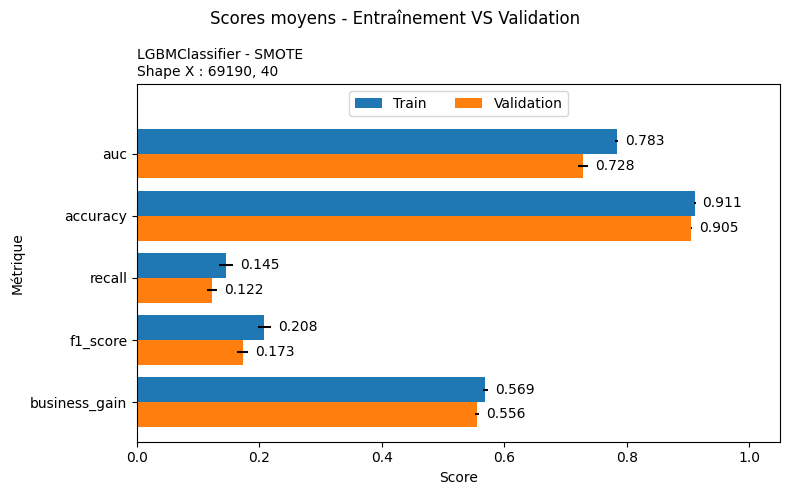

In [170]:
fig = evaluator6.plot_evaluation_scores()

In [111]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")

### Plot Matrice confusion

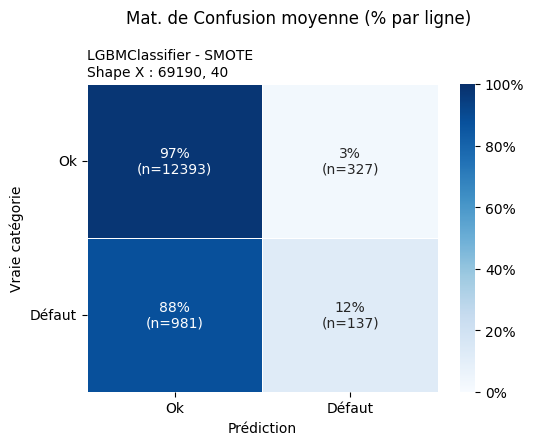

In [112]:
fig = evaluator6.plot_conf_mat()
fig

In [113]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")

### Plot Roc Curve

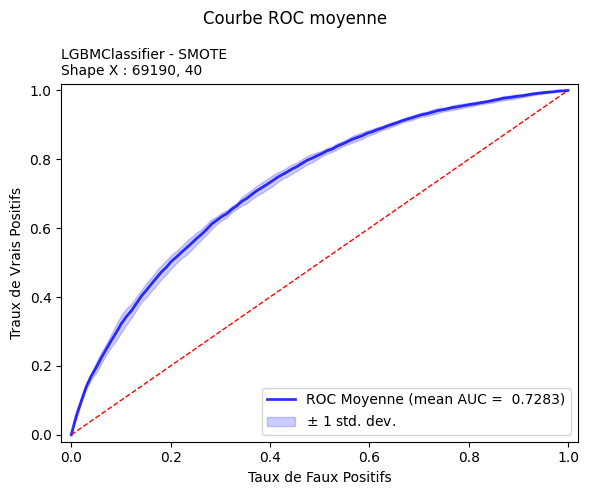

In [114]:
fig = evaluator6.plot_roc_curve()

In [115]:
with mlflow.start_run(run_id=run_id):
    img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")

### Ajout au tableau comparatif

In [116]:
cmp.add(evaluator6)
cmp.display()

Comparatif Rééquilibrage


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40
2,LogisticRegression,class_weight=balanced,0.6840,0.7477,0.6888,0.6781,0.2603,1.2,69190,40
3,LogisticRegression,SMOTE,0.6833,0.7456,0.6897,0.6754,0.2602,1.3,69190,40
4,LGBMClassifier,Unbalanced,0.5274,0.7642,0.9192,0.0424,0.0781,0.3,69190,40
5,LGBMClassifier,class_weight=balanced,0.6942,0.7643,0.7560,0.6178,0.2903,0.3,69190,40
6,LGBMClassifier,SMOTE,0.5555,0.7283,0.9054,0.1224,0.1728,0.6,69190,40


# Meilleure stratégie de rééquilibrage

In [117]:
# On trie le tableau par Business Gain de validation
cmp.display(sort_by=["business_gain"])

Comparatif Rééquilibrage trié par ['business_gain']


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,n_rows,n_feat.
5,LGBMClassifier,class_weight=balanced,0.6942,0.7643,0.7560,0.6178,0.2903,0.3,69190,40
2,LogisticRegression,class_weight=balanced,0.6840,0.7477,0.6888,0.6781,0.2603,1.2,69190,40
3,LogisticRegression,SMOTE,0.6833,0.7456,0.6897,0.6754,0.2602,1.3,69190,40
6,LGBMClassifier,SMOTE,0.5555,0.7283,0.9054,0.1224,0.1728,0.6,69190,40
4,LGBMClassifier,Unbalanced,0.5274,0.7642,0.9192,0.0424,0.0781,0.3,69190,40
1,LogisticRegression,Unbalanced,0.5139,0.7477,0.9190,0.0123,0.0240,1.2,69190,40
0,DummyClassifier,Unbalanced,0.5085,0.5000,0.9192,0.0000,0.0000,0.0,69190,424


In [118]:
"""
Avec les paramètres par défaut, la stratégie de rééquilibrage la plus prometteuse est class_weighted.
Celle-ci peut-être améliorée en jouant sur les poids,
tout comme SMOTE pourrait être amélioré en jourant sur le nombre de voisins
"""

'\nAvec les paramètres par défaut, la stratégie de rééquilibrage la plus prometteuse est class_weighted.\nCelle-ci peut-être améliorée en jouant sur les poids,\ntout comme SMOTE pourrait être amélioré en jourant sur le nombre de voisins\n'

In [119]:
# Sauvegarde de l'objet
save_pkl(cmp, filename="cmp_balancing", title="Comparatif Rééquilibrage")
# Sauvegarde en tant que liste de dictionnaires réutilisable dans une autre classe car
# si on modifie la classe en cours de projet, on ne pourra plus lire l'objet.
cmp.save("cmp_balancing_table")

Comparatif Rééquilibrage engistré(e) dans models/cmp_balancing.pkl
Tableau comparatif enregistré dans models/cmp_balancing_table.pkl


# Nombre de features idéal avec RFECV pour le train non réduit

## Lecture du train

In [ ]:
X, y = read_train()

# Meilleures features pour chaque modèle - RFECV

## Meilleures features pour le modèle REGLOG (RFECV sur La Régression Logistique avec class_weight='balanced')

In [321]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs", class_weight="balanced", n_jobs=14, max_iter=500
            ),
        ),
    ]
)

In [322]:
t0 = time.time()
selector_logreg = RfecvSelector(
    pipe=pipe,
    min_features=50,
    cv=5,
)
selector_logreg.fit(X, y)
duration = time.time() - t0
print(f"\nDurée (hh:mm:ss) : {format_time(duration)}")

self.model type <class 'sklearn.linear_model._logistic.LogisticRegression'>
424 features -> Auc = 0.7674
423 features -> Auc = 0.7674
422 features -> Auc = 0.7674
421 features -> Auc = 0.7674
420 features -> Auc = 0.7674
419 features -> Auc = 0.7674
418 features -> Auc = 0.7674
417 features -> Auc = 0.7674
416 features -> Auc = 0.7674
415 features -> Auc = 0.7674
414 features -> Auc = 0.7675
413 features -> Auc = 0.7675
412 features -> Auc = 0.7675
411 features -> Auc = 0.7675
410 features -> Auc = 0.7675
409 features -> Auc = 0.7675
408 features -> Auc = 0.7675
407 features -> Auc = 0.7675
406 features -> Auc = 0.7675
405 features -> Auc = 0.7675
404 features -> Auc = 0.7675
403 features -> Auc = 0.7675
402 features -> Auc = 0.7676
401 features -> Auc = 0.7676
400 features -> Auc = 0.7676
399 features -> Auc = 0.7676
398 features -> Auc = 0.7676
397 features -> Auc = 0.7676
396 features -> Auc = 0.7676
395 features -> Auc = 0.7676
394 features -> Auc = 0.7677
393 features -> Auc = 0.7

In [323]:
print(f"{len(selector_logreg.best_features)} features ont été sélectionnées :")
print(selector_logreg.best_features)
print("Meilleur score de validation (AUC) :", selector_logreg.best_score)

219 features ont été sélectionnées :
['CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NONLIVINGAPARTMENTS_AVG', 'EMERGENCYSTATE_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_TO_GOODS_RATIO', 'ANNUITY_TO_IN

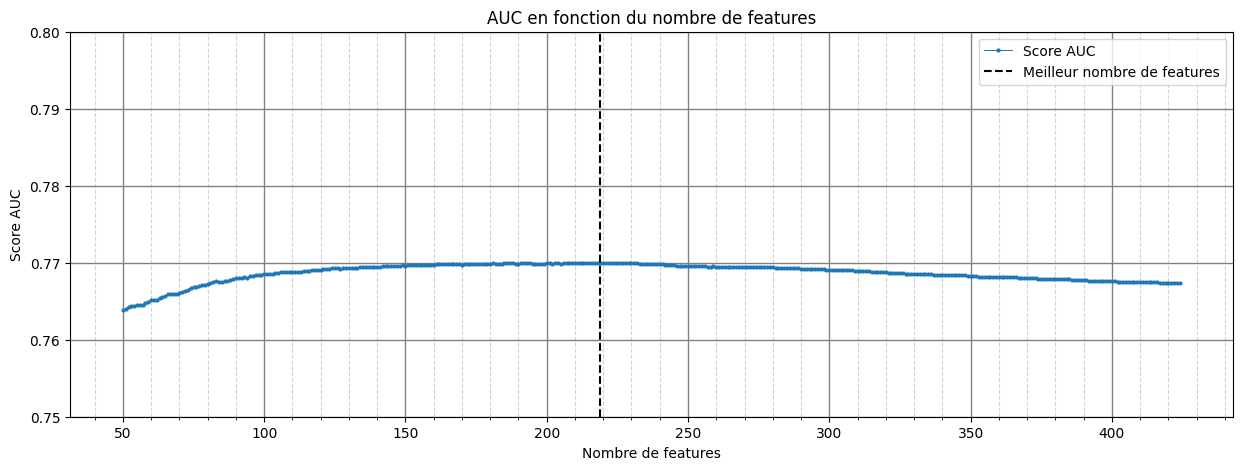

In [324]:
selector_logreg.plot_scores(y_lim=[0.75, 0.8])

### Sauvegarde

In [325]:
save_features(selector_logreg.best_features, "features_rfecv_logreg")

Liste des features (Nb = 219) engistrée dans models/features_rfecv_logreg.pkl


## Meilleures features pour le modèle LightGBM (RFECV sur LightGBM avec classweight)

In [ ]:
X, y = read_train()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 426 entries, SK_ID_CURR to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(146), float64(249), int64(31)
memory usage: 532.2 MB
Memory usage of dataframe is 532.18 MB
Memory usage after optimization is: 302.55 MB
Decreased by 43.1%


### RFECV avec lgbm class_weighted

In [ ]:
start = time.time()
estimator_weighted = LGBMClassifier(
    class_weight="balanced",
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,
)

t0 = time.time()
selector_lightgbm = RfecvSelector(
    pipe=estimator_weighted,
    min_features=4,
    cv=5,
    step=1,
)
selector_lightgbm.fit(X, y)

duration = time.time() - t0
print(f"\nDurée (hh:mm:ss) : {format_time(duration)}")

self.model type <class 'lightgbm.sklearn.LGBMClassifier'>
424 features -> Auc = 0.7804
423 features -> Auc = 0.7804
422 features -> Auc = 0.7804
421 features -> Auc = 0.7804
420 features -> Auc = 0.7804
419 features -> Auc = 0.7804
418 features -> Auc = 0.7804
417 features -> Auc = 0.7804
416 features -> Auc = 0.7804
415 features -> Auc = 0.7804
414 features -> Auc = 0.7804
413 features -> Auc = 0.7804
412 features -> Auc = 0.7804
411 features -> Auc = 0.7804
410 features -> Auc = 0.7804
409 features -> Auc = 0.7803
408 features -> Auc = 0.7803
407 features -> Auc = 0.7803
406 features -> Auc = 0.7803
405 features -> Auc = 0.7803
404 features -> Auc = 0.7803
403 features -> Auc = 0.7803
402 features -> Auc = 0.7803
401 features -> Auc = 0.7805
400 features -> Auc = 0.7803
399 features -> Auc = 0.7803
398 features -> Auc = 0.7803
397 features -> Auc = 0.7803
396 features -> Auc = 0.7803
395 features -> Auc = 0.7803
394 features -> Auc = 0.7803
393 features -> Auc = 0.7803
392 features -

In [ ]:
print(f"{len(selector_lightgbm.best_features)} features ont été sélectionnées :")
print(selector_lightgbm.best_features)
print("Meilleur score de validation (AUC) :", selector_lightgbm.best_score)

269 features ont été sélectionnées :
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BASEMENTAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAREA_MODE', 'LANDAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_TO_ANNUITY_RATIO', 'CREDIT_TO_GOODS_RATIO', 'ANNUITY_TO_INCOME_RATIO', 'INCOME_TO_BIRTH_RATIO', 'NAME_CONTRACT_TYPE_Revolvi

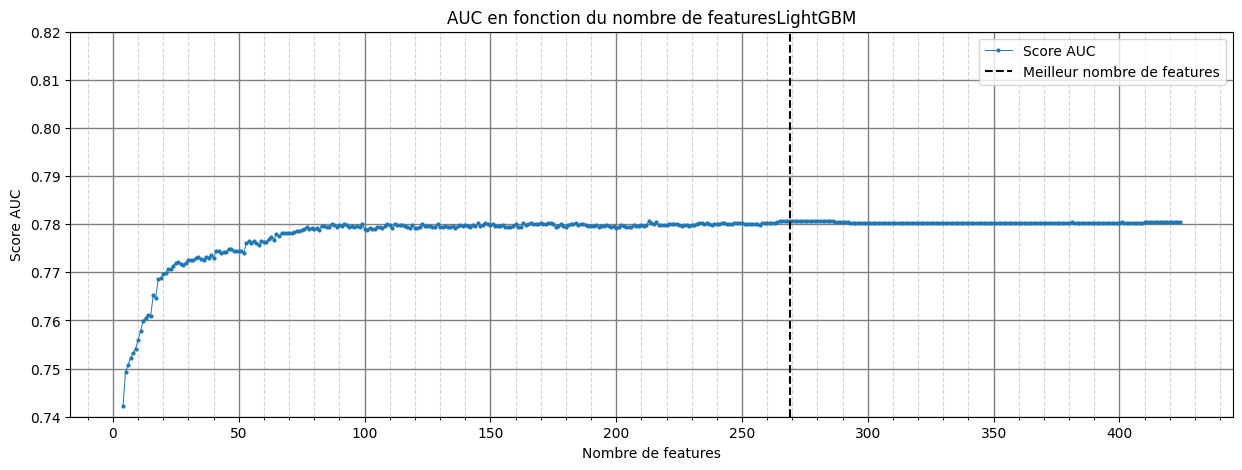

In [ ]:
selector_lightgbm.plot_scores(y_lim=[0.74, 0.82], model_name="LightGBM")

In [ ]:
selector_lightgbm.best_score

0.7806667567520555

In [ ]:
len(selector_lightgbm.best_features)

269

In [ ]:
selector_lightgbm.get_history(n_features_start=80, n_features_end=100)

,iteration,n_features,auc,features
332,333,92,0.780115,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, LANDAREA_MEDI, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_..."
337,338,87,0.780059,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_RATIO, INCOME_T..."
325,326,99,0.780002,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, LANDAREA_MEDI, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_..."
331,332,93,0.779937,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, LANDAREA_MEDI, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_..."
334,335,90,0.779891,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, LANDAREA_MEDI, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_..."
336,337,88,0.779816,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_RATIO, INCOME_T..."
341,342,83,0.779690,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_RATIO, INCOME_TO_BIRTH_RATIO, NA..."
329,330,95,0.779674,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, LANDAREA_MEDI, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_..."
333,334,91,0.779670,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, YEARS_BEGINEXPLUATATION_MODE, LIVINGAREA_MODE, LANDAREA_MEDI, TOTALAREA_MODE, DEF_30_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, CREDIT_TO_ANNUITY_RATIO, CREDIT_TO_GOODS_RATIO, ANNUITY_TO_INCOME_..."
340,341,84,0.779591,"[CODE_GENDER, AMT_ANNUITY, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, REGION_RATING_C

In [ ]:
features = selector_lightgbm.best_features
"""train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv"))[
    features + ["TARGET"]
]
train = reduce_memory_cudf(train)
X = train[features].to_pandas()
y = train["TARGET"].to_pandas()
print("\nInfo X_train")
X.info()
del train"""
X, y = read_train(features=features)
gc.collect()
cp._default_memory_pool.free_all_blocks()
model = LGBMClassifier(
    class_weight="balanced",
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)

eval = EvaluatorCV(pipe=model, device="cpu", cv=5, random_state=VAL_SEED)

eval.evaluate(X, y)
_ = eval.get_business_gain()

Memory usage of dataframe is 407.02 MB
Memory usage after optimization is: 228.42 MB
Decreased by 43.9%

Info X_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230634 entries, 0 to 230633
Columns: 269 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_VAR
dtypes: bool(48), float32(188), float64(27), int32(4), int64(2)
memory usage: 230.5 MB
Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:18
Business gain Train : 0.7601,	Business gain Validation : 0.7094


In [ ]:
best_features = selector_lightgbm.get_features()
features_92 = selector_lightgbm.get_features(n_features=92)
features_87 = selector_lightgbm.get_features(n_features=87)

Memory usage of dataframe is 532.18 MB
Memory usage after optimization is: 302.55 MB
Decreased by 43.1%


In [314]:
train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv"))
train = reduce_memory_cudf(train).to_pandas()
y = train["TARGET"]

cmp_rfecv = ComparativeTable("Comparatif Nombre de features")
cmp_rfecv.set_duration_format({"fit_time": "{:.1f}"})
cmp_rfecv.set_column_order(
    [
        "model_name",
        "balancing",
        "business_gain",
        "auc",
        "accuracy",
        "recall",
        "f1_score",
        "fit_time",
        "fn",
        "n_feat.",
    ]
)

for features in [best_features, features_92, features_87]:
    X = train[features]
    model = LGBMClassifier(
        class_weight="balanced",
        n_threads=14,
        objective="binary",
        random_state=VAL_SEED,
        verbosity=-1,  # Pour ne pas voir les logs
    )

    eval = EvaluatorCV(pipe=model, device="cpu", cv=5, random_state=VAL_SEED)

    eval.evaluate(X, y)
    _ = eval.get_business_gain()
    cmp_rfecv.add(eval)

Memory usage of dataframe is 532.18 MB
Memory usage after optimization is: 302.55 MB
Decreased by 43.1%
Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:18
Business gain Train : 0.7601,	Business gain Validation : 0.7094
Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:10
Business gain Train : 0.7576,	Business gain Validation : 0.7103
Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:10
Business gain Train : 0.7571,	Business gain Validation : 0.7105


In [315]:
cmp_rfecv.display()

Comparatif Nombre de features


,model_name,balancing,business_gain,auc,accuracy,recall,f1_score,fit_time,fn,n_feat.
0,LGBMClassifier,class_weight=balanced,0.7094,0.7807,0.7335,0.6795,0.2917,2.7,1194.2000,269
1,LGBMClassifier,class_weight=balanced,0.7103,0.7801,0.7327,0.6825,0.2921,1.3,1183.0000,92
2,LGBMClassifier,class_weight=balanced,0.7105,0.7801,0.7319,0.6839,0.2918,1.2,1177.8000,87


In [ ]:
selector_lightgbm.best_score

0.7806667567520555

### Sauvegarde

In [ ]:
save_features(selector_lightgbm.best_features, "features_rfecv_lightgbm_best")
save_features(features_87, "features_rfecv_lightgbm")

Liste des features (Nb = 269) engistrée dans models/features_rfecv_lightgbm_best.pkl
Liste des features (Nb = 87) engistrée dans models/features_rfecv_lightgbm.pkl


In [332]:
train = cudf.read_csv(os.path.join(DATA_CLEAN_DIR, "01_v2_vif_train.csv"))
train_lightgbm = train[["SK_ID_CURR", "TARGET"] + features_87]

filepath = os.path.join(DATA_CLEAN_DIR, "01_v3_rfecv_lightgbm_train.csv")
train_lightgbm.to_csv(filepath, index=False)
print(f"Train pour lightgbm enregistré dans {filepath}")

Train pour lightgbm enregistré dans data/cleaned/01_v3_rfecv_lightgbm_train.csv


# Evaluation en validation croisée des modèles sur le nombre de features optimal

## Création de l'expérience mlflow

In [558]:
_ = start_mlflow_ui()

L'interface web mlflow est déjà disponible à l'adresse http://127.0.0.1:5000


In [559]:
exp_evaluation_id = create_or_load_experiment(
    name="draft_model_comparison_rfecv_features",
    description="Evaluation des modèles non optimisés en validation croisée sur le nombre optimal de features",
)

Création de l'expérience MLFlow 'draft_model_comparison_rfecv_features', ID = 147260485155584645


### Régression logistique sur le nombre de features optimal RFECV

#### Données

In [560]:
features = read_features("features_rfecv_logreg")
X, y = read_train(features=features)

Liste des features (Nb = 219) lue dans models/features_rfecv_logreg.pkl
Memory usage of dataframe is 280.30 MB
Memory usage after optimization is: 162.41 MB
Decreased by 42.1%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Columns: 219 entries, CODE_GENDER to CC_CNT_DRAWINGS_CURRENT_MEAN
dtypes: bool(73), float32(124), float64(17), int32(3), int64(2)
memory usage: 163.0 MB


#### Exécution

In [561]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs", class_weight="balanced", n_jobs=14, max_iter=100
            ),
        ),
    ]
)

evaluator7 = EvaluatorCV(pipe=pipe, device="cpu", cv=5, random_state=VAL_SEED)
run_name = "logreg_balanced_not_optim"
run_tags = {"balancing": evaluator7.balance_str, "optim": "Non"}
run_description = "LogReg class_weight features RFECV Hyperparamètres non optimisés"
with mlflow.start_run(
    experiment_id=exp_evaluation_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator7.evaluate(X, y)
    _ = evaluator7.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:28
Business gain Train : 0.7063,	Business gain Validation : 0.7026


#### Traçage des scores et des paramètres du modèle dans mlflow

In [ ]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator7.get_mean_val_scores(prefix="val_")
    train_scores = evaluator7.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = evaluator7.get_model_params()
    # Finalement on s'aperçoit que loguer les paramètres du business_gain et le threshold_prob utilisé dans les params,
    # même en les préfixant, n'est pas du tout pratique (peu lisible).
    # Donc on logue uniquement les paramètres du modèle dans params et
    # on loguera le reste (business gain et threshold_prob) dans les artifacts.
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

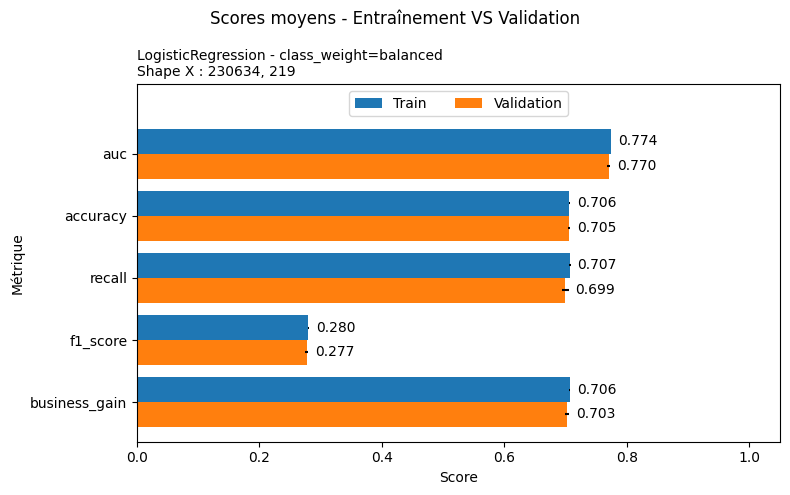

In [563]:
fig = evaluator7.plot_evaluation_scores()

In [564]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_evaluation_scores")

### Plot Matrice confusion

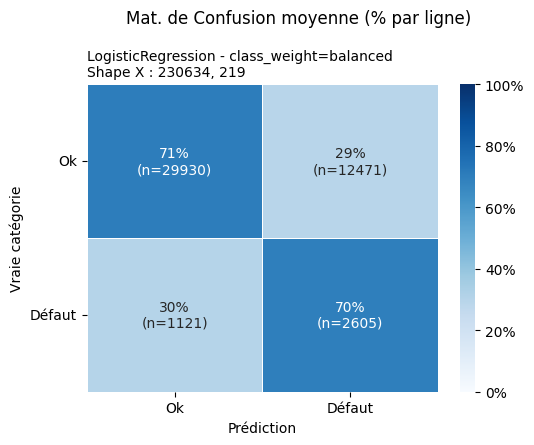

In [565]:
fig = evaluator7.plot_conf_mat()
fig

In [566]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_confusion_matrix")

### Plot Roc Curve

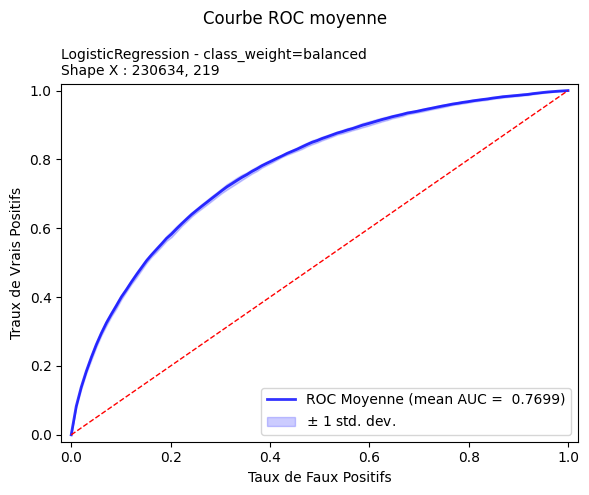

In [567]:
fig = evaluator7.plot_roc_curve()

In [ ]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_roc_curve")

### Loguer les features

In [ ]:
"""
A ce stade on ne logue pas de dataset. Cela nous obligerait à enregistrer le dataset pour chaque modèle
et à recaster les int.
On logue la liste des features utilisées sous forme de json dans les artifacts.
"""

In [569]:
with mlflow.start_run(run_id=run_id):
    log_features(X)

### Loguer les paramètres du business_gain et le threshold_prob utilisé

In [585]:
with mlflow.start_run(run_id=run_id):
    bg_params = evaluator7.get_bg_params()
    threshold_prob = evaluator7.threshold_prob
    log_scoring_params(bg_params, threshold_prob)

### Loguer le modèle RegLog

In [ ]:
"""
Pour loguer le modèle dans mlflow, il doit être fitté. Or celui-ci est fitté uniquement sur le dernier fold.
Donc on le réentraîne sur le train entier.
A ce stade on le logue sans signature (cela nous obligerait à caster les int),
on ne le versionne pas non plus car il est encore en cours de développement,
nous devons encore l'optimiser.
"""

"\nPour loguer le modèle dans mlflow, il doit être fitté. Or celui-ci est fitté uniquement sur le dernier fold.\nDonc on le réentraîne sur le train entier.\nOn ne le versionne pas car il est encore en cours de développement, nous devons encore l'optimiser.\nNous relisons le train car celui-ci n'est pas optimisé et ne contient pas d'int en taille inférieur à int64 avec des NaN.\nEn effet les pandas DataFrame n'autorisent pas les NaN dans les int à moins qu'il s'agisse de Int64\n"

In [571]:
pipe.fit(X, y)
with mlflow.start_run(run_id=run_id):
    mlflow.sklearn.log_model(pipe, artifact_path="model")

### LightGBM sur le nombre de features optimal RFECV

#### Données

In [572]:
features = read_features("features_rfecv_lightgbm")

Liste des features (Nb = 87) lue dans models/features_rfecv_lightgbm.pkl


In [573]:
X, y = read_train(features=features)

Memory usage of dataframe is 155.67 MB
Memory usage after optimization is: 92.33 MB
Decreased by 40.7%

Info X_train
<class 'pandas.core.frame.DataFrame'>
Index: 230634 entries, 127032 to 421871
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   CODE_GENDER                            230634 non-null  int32  
 1   AMT_ANNUITY                            230626 non-null  float32
 2   REGION_POPULATION_RELATIVE             230634 non-null  float32
 3   DAYS_BIRTH                             230634 non-null  int64  
 4   DAYS_EMPLOYED                          189075 non-null  float32
 5   DAYS_REGISTRATION                      230634 non-null  float32
 6   DAYS_ID_PUBLISH                        230634 non-null  int64  
 7   OWN_CAR_AGE                            78227 non-null   float32
 8   REGION_RATING_CLIENT_W_CITY            230634 non-null  int32  
 9   EXT_SOUR

In [574]:
X.head()

,CODE_GENDER,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
127032,1,16672.5,0.031329,-23528,NaN,-11467.0,-4116,NaN,2,NaN,...,9644.332031,2.121753e+05,5757.120117,-26.0,-19035.0,NaN,NaN,NaN,NaN,NaN
148207,1,21546.0,0.028663,-12273,-3034.0,-3557.0,-3557,NaN,2,0.628213,...,5966.736328,2.148025e+05,2629.800049,-379.0,-75261.0,NaN,NaN,NaN,NaN,NaN
343318,1,53775.0,0.011703,-20583,-611.0,-5214.0,-3748,21.0,2,0.860969,...,72310.125000,1.663133e+06,8838.495117,-206.0,-28450.0,NaN,NaN,NaN,NaN,NaN
307778,1,22977.0,0.009630,-8089,-876.0,-8089.0,-712,NaN,2,0.243992,...,23757.322266,1.425439e+05,23755.859375,-468.0,-3261.0,NaN,NaN,NaN,NaN,NaN
260591,0,54688.5,0.007330,-23282,-1979.0,-6216.0,-4940,NaN,2,NaN,...,6344.168457,1.459159e+05,3312.629883,-1250.0,-39033.0,NaN,NaN,NaN,NaN,NaN


#### Exécution

In [575]:
model = LGBMClassifier(
    class_weight="balanced",
    n_threads=14,
    objective="binary",
    random_state=VAL_SEED,
    verbosity=-1,  # Pour ne pas voir les logs
)

evaluator8 = EvaluatorCV(pipe=model, device="cpu", cv=5, random_state=VAL_SEED)
run_name = "lightgbm_balanced_not_optim"
run_tags = {"balancing": evaluator8.balance_str, "optim": "Non"}
run_description = "LightGBM class_weight features RFECV Hyperparamètres non optimisés"

with mlflow.start_run(
    experiment_id=exp_evaluation_id,
    run_name=run_name,
    tags=run_tags,
    description=run_description,
) as run:
    run_id = run.info.run_id
    evaluator8.evaluate(X, y)
    _ = evaluator8.get_business_gain()

Durée de l'évaluation en validation croisée sur cpu (5 folds): 0:00:10
Business gain Train : 0.7571,	Business gain Validation : 0.7105


#### Traçage des scores et des paramètres dans mlflow

In [576]:
with mlflow.start_run(run_id=run_id):
    val_scores = evaluator8.get_mean_val_scores(prefix="val_")
    train_scores = evaluator8.get_mean_train_scores(prefix="train_")
    scores = {**train_scores, **val_scores}
    mlflow.log_metrics(scores)
    params = evaluator8.get_model_params()
    mlflow.log_params(params)

### Plot Scores d'entraînement et de validation

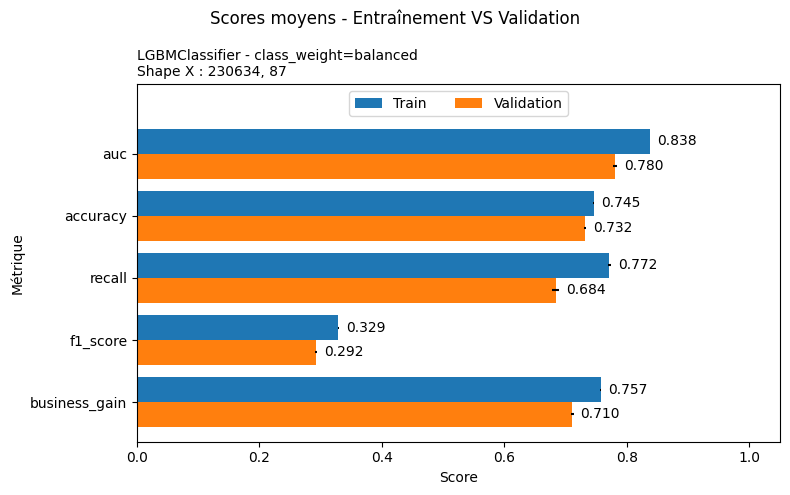

In [577]:
fig = evaluator8.plot_evaluation_scores()

In [578]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_evaluation_scores")
    """img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_evaluation_scores.png")"""

### Plot Matrice confusion

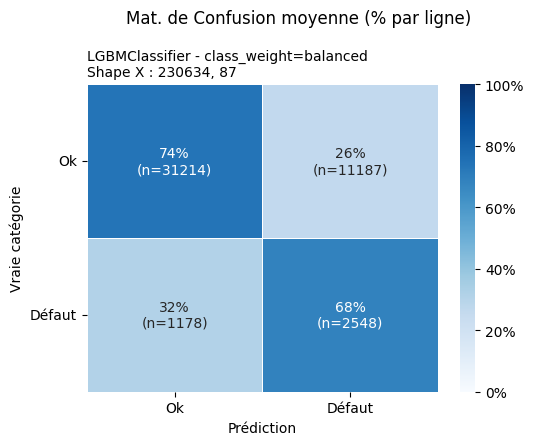

In [579]:
fig = evaluator8.plot_conf_mat()
fig

In [580]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_confusion_matrix")
    """img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_confusion_matrix.png")"""

### Plot Roc Curve

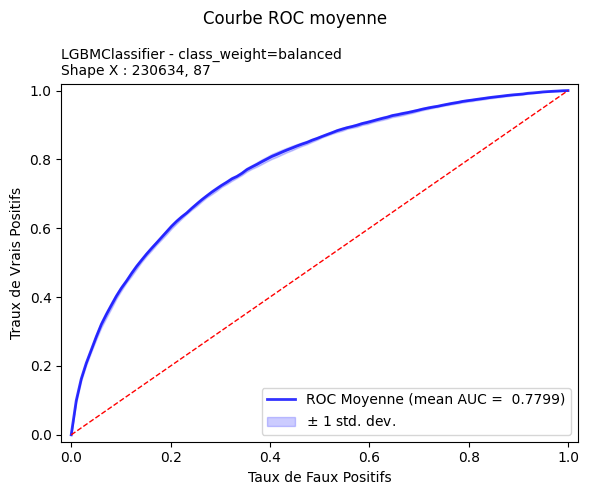

In [581]:
fig = evaluator8.plot_roc_curve()

In [582]:
with mlflow.start_run(run_id=run_id):
    log_image(fig, "plot_roc_curve")
    """img = pil_image_from_fig(fig)
    mlflow.log_image(img, artifact_file="plot_roc_curve.png")"""

### Log du modèle LightGBM

In [583]:
model.fit(X, y)
with mlflow.start_run(run_id=run_id):
    mlflow.sklearn.log_model(model, artifact_path="model")

### Log des features LightGBM

In [584]:
with mlflow.start_run(run_id=run_id):
    log_features(X)

### Log des paramètres de scoring LightGBM (Business_gain et threshold_prob)

### Loguer les paramètres du business_gain et le threshold_prob utilisé

In [586]:
with mlflow.start_run(run_id=run_id):
    bg_params = evaluator8.get_bg_params()
    threshold_prob = evaluator8.threshold_prob
    log_scoring_params(bg_params, threshold_prob)